In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

In [2]:
auto = pd.read_csv("train_auto.csv", index_col="INDEX")

In [3]:
auto.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
auto.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [5]:
np.sum(1*auto.isna())

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

In [6]:
auto.nunique()

TARGET_FLAG       2
TARGET_AMT     1949
KIDSDRIV          5
AGE              60
HOMEKIDS          6
YOJ              21
INCOME         6612
PARENT1           2
HOME_VAL       5106
MSTATUS           2
SEX               2
EDUCATION         5
JOB               8
TRAVTIME         97
CAR_USE           2
BLUEBOOK       2789
TIF              23
CAR_TYPE          6
RED_CAR           2
OLDCLAIM       2857
CLM_FREQ          6
REVOKED           2
MVR_PTS          13
CAR_AGE          30
URBANICITY        2
dtype: int64

In [7]:
X = auto.drop(["TARGET_FLAG", "TARGET_AMT"], axis=1)
y = auto["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [8]:
def clean_and_prep(df):
    
    X = df.copy()
    
    X["INCOME"] = df["INCOME"].str.replace(',', '').str.replace('$', '').astype(float)
    X["HOME_VAL"] = df["HOME_VAL"].str.replace(',', '').str.replace('$', '').astype(float)
    X["OLDCLAIM"] = df["OLDCLAIM"].str.replace(',', '').str.replace('$', '').astype(float)
    X["BLUEBOOK"] = df["BLUEBOOK"].str.replace(',', '').str.replace('$', '').astype(float)
    
    cat_cols = ["PARENT1", "MSTATUS", "SEX", "EDUCATION", "JOB", "CAR_USE",
                "CAR_TYPE", "RED_CAR", "REVOKED", "URBANICITY"]
    num_cols = X.columns[~X.columns.isin(cat_cols)]
    
    names = [*cat_cols, *num_cols]
    
    categorical_encoder = make_pipeline(
        SimpleImputer(strategy="constant"),
        OrdinalEncoder()
    )
    
    preprocessor = make_column_transformer(
        (categorical_encoder, cat_cols),
        (SimpleImputer(strategy='mean'), num_cols),
         remainder = 'passthrough'
    )
     
    X = preprocessor.fit_transform(X)
    X = pd.DataFrame(X, columns=names)
    
    return X

In [9]:
X_train = clean_and_prep(X_train)
X_test = clean_and_prep(X_test)

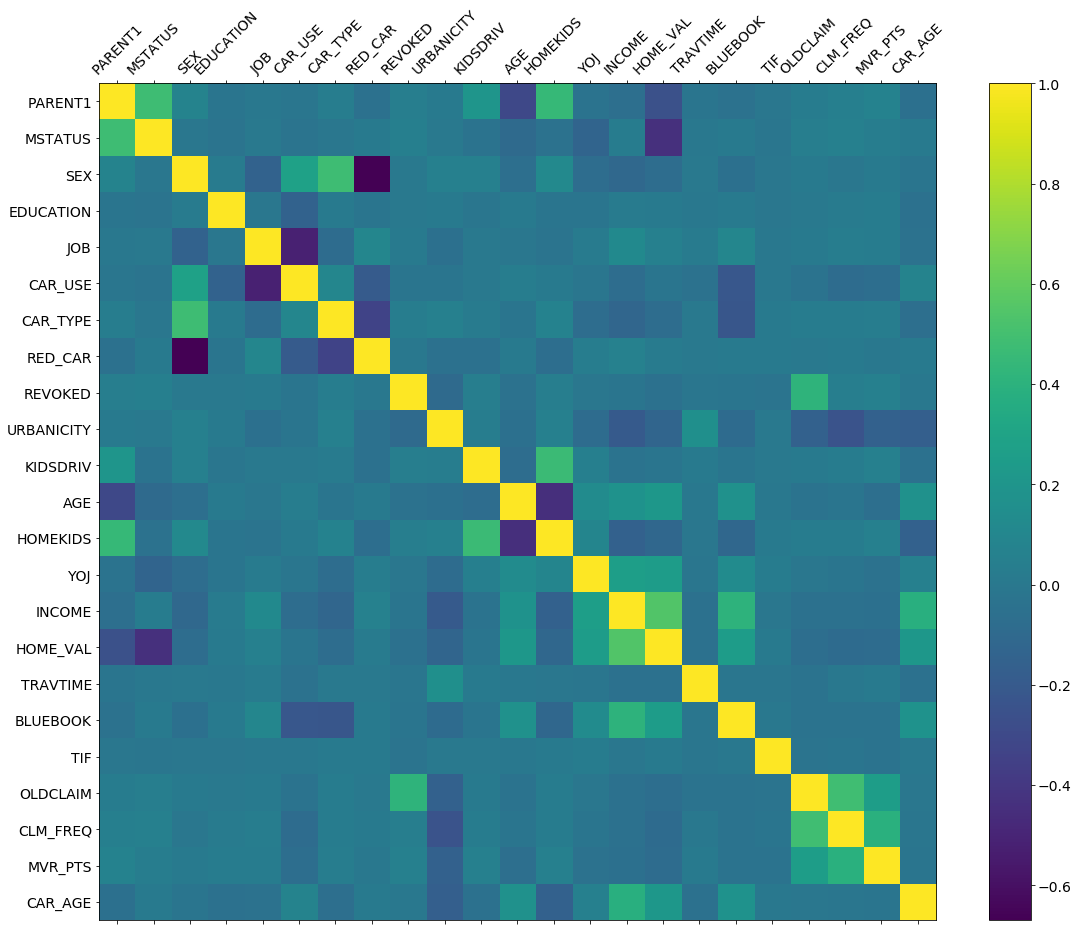

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [11]:
cat_cols = ["PARENT1", "MSTATUS", "SEX", "EDUCATION", "JOB", "CAR_USE",
                "CAR_TYPE", "RED_CAR", "REVOKED", "URBANICITY"]
cat_ind = [X_train.columns.get_loc(cat_cols[i]) for i in range(len(cat_cols))]

In [12]:
fit_params = {"eval_metric" : 'auc', 
              "eval_set" : [(X_test, y_test)], 
              "categorical_feature": cat_ind
             }

gridParams = {'n_estimators': [500], 
              'num_leaves': [8], 
              'boosting_type' : ['dart'], 
              'max_depth': [8],
              'reg_lambda': [1.2]
             }

estimator = LGBMClassifier(objective='binary')

gsearch = GridSearchCV(estimator=estimator, param_grid=gridParams, n_jobs=-1, cv=5)
lgb_model = gsearch.fit(X_train, y_train, **fit_params)

# Print the best parameters found
print(gsearch.best_params_)
print(gsearch.best_score_)

C:\ML\Python\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ML\Python\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ML\Python\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ML\Python\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 0.755468	valid_0's binary_logloss: 0.573688
[2]	valid_0's auc: 0.768301	valid_0's binary_logloss: 0.560958
[3]	valid_0's auc: 0.776253	valid_0's binary_logloss: 0.550993
[4]	valid_0's auc: 0.783716	valid_0's binary_logloss: 0.540884
[5]	valid_0's auc: 0.786754	valid_0's binary_logloss: 0.533812
[6]	valid_0's auc: 0.790745	valid_0's binary_logloss: 0.525855
[7]	valid_0's auc: 0.790474	valid_0's binary_logloss: 0.520402
[8]	valid_0's auc: 0.789499	valid_0's binary_logloss: 0.523447
[9]	valid_0's auc: 0.79361	valid_0's binary_logloss: 0.516554
[10]	valid_0's auc: 0.799335	valid_0's binary_logloss: 0.510434
[11]	valid_0's auc: 0.800808	valid_0's binary_logloss: 0.505233
[12]	valid_0's auc: 0.801577	valid_0's binary_logloss: 0.507016
[13]	valid_0's auc: 0.802175	valid_0's binary_logloss: 0.503202
[14]	valid_0's auc: 0.803234	valid_0's binary_logloss: 0.498979
[15]	valid_0's auc: 0.804296	valid_0's binary_logloss: 0.495461
[16]	valid_0's auc: 0.804769	valid_0's binary_logl

[158]	valid_0's auc: 0.823385	valid_0's binary_logloss: 0.454848
[159]	valid_0's auc: 0.823432	valid_0's binary_logloss: 0.455178
[160]	valid_0's auc: 0.823395	valid_0's binary_logloss: 0.455584
[161]	valid_0's auc: 0.823622	valid_0's binary_logloss: 0.454821
[162]	valid_0's auc: 0.82359	valid_0's binary_logloss: 0.455105
[163]	valid_0's auc: 0.823541	valid_0's binary_logloss: 0.454629
[164]	valid_0's auc: 0.823649	valid_0's binary_logloss: 0.453786
[165]	valid_0's auc: 0.823314	valid_0's binary_logloss: 0.453303
[166]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.452923
[167]	valid_0's auc: 0.823251	valid_0's binary_logloss: 0.452577
[168]	valid_0's auc: 0.823797	valid_0's binary_logloss: 0.451845
[169]	valid_0's auc: 0.823953	valid_0's binary_logloss: 0.451321
[170]	valid_0's auc: 0.823994	valid_0's binary_logloss: 0.451575
[171]	valid_0's auc: 0.824104	valid_0's binary_logloss: 0.450845
[172]	valid_0's auc: 0.824132	valid_0's binary_logloss: 0.451137
[173]	valid_0's auc: 0.824

[314]	valid_0's auc: 0.826304	valid_0's binary_logloss: 0.444384
[315]	valid_0's auc: 0.826324	valid_0's binary_logloss: 0.444479
[316]	valid_0's auc: 0.826703	valid_0's binary_logloss: 0.444081
[317]	valid_0's auc: 0.826556	valid_0's binary_logloss: 0.444134
[318]	valid_0's auc: 0.826639	valid_0's binary_logloss: 0.443975
[319]	valid_0's auc: 0.826652	valid_0's binary_logloss: 0.444055
[320]	valid_0's auc: 0.826622	valid_0's binary_logloss: 0.444053
[321]	valid_0's auc: 0.82668	valid_0's binary_logloss: 0.444075
[322]	valid_0's auc: 0.826854	valid_0's binary_logloss: 0.443762
[323]	valid_0's auc: 0.826742	valid_0's binary_logloss: 0.443697
[324]	valid_0's auc: 0.826785	valid_0's binary_logloss: 0.443751
[325]	valid_0's auc: 0.826987	valid_0's binary_logloss: 0.443503
[326]	valid_0's auc: 0.826998	valid_0's binary_logloss: 0.443571
[327]	valid_0's auc: 0.827069	valid_0's binary_logloss: 0.443426
[328]	valid_0's auc: 0.827062	valid_0's binary_logloss: 0.443509
[329]	valid_0's auc: 0.826

[457]	valid_0's auc: 0.827191	valid_0's binary_logloss: 0.441998
[458]	valid_0's auc: 0.827267	valid_0's binary_logloss: 0.441959
[459]	valid_0's auc: 0.827445	valid_0's binary_logloss: 0.44176
[460]	valid_0's auc: 0.827447	valid_0's binary_logloss: 0.441779
[461]	valid_0's auc: 0.827281	valid_0's binary_logloss: 0.441865
[462]	valid_0's auc: 0.827259	valid_0's binary_logloss: 0.441896
[463]	valid_0's auc: 0.827258	valid_0's binary_logloss: 0.441929
[464]	valid_0's auc: 0.827397	valid_0's binary_logloss: 0.441833
[465]	valid_0's auc: 0.827463	valid_0's binary_logloss: 0.441735
[466]	valid_0's auc: 0.827471	valid_0's binary_logloss: 0.441762
[467]	valid_0's auc: 0.827469	valid_0's binary_logloss: 0.441693
[468]	valid_0's auc: 0.827481	valid_0's binary_logloss: 0.441696
[469]	valid_0's auc: 0.827511	valid_0's binary_logloss: 0.441683
[470]	valid_0's auc: 0.827526	valid_0's binary_logloss: 0.441646
[471]	valid_0's auc: 0.827288	valid_0's binary_logloss: 0.441889
[472]	valid_0's auc: 0.827

In [13]:
estimator = LGBMClassifier(objective='binary', boosting_type='dart', max_depth=8,
                           n_estimators=500, num_leaves=8, reg_lambda=1.2)

lgbc = estimator.fit(X_train, y_train, **fit_params)

scores = cross_val_score(lgbc, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
y_pred = lgbc.predict(X_test)

print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")
print(MSE(y_test, y_pred))
confusion_matrix(y_test, y_pred)

[1]	valid_0's auc: 0.755468	valid_0's binary_logloss: 0.573688
[2]	valid_0's auc: 0.768301	valid_0's binary_logloss: 0.560958
[3]	valid_0's auc: 0.776253	valid_0's binary_logloss: 0.550993
[4]	valid_0's auc: 0.783716	valid_0's binary_logloss: 0.540884
[5]	valid_0's auc: 0.786754	valid_0's binary_logloss: 0.533812
[6]	valid_0's auc: 0.790745	valid_0's binary_logloss: 0.525855
[7]	valid_0's auc: 0.790474	valid_0's binary_logloss: 0.520402
[8]	valid_0's auc: 0.789499	valid_0's binary_logloss: 0.523447
[9]	valid_0's auc: 0.79361	valid_0's binary_logloss: 0.516554
[10]	valid_0's auc: 0.799335	valid_0's binary_logloss: 0.510434
[11]	valid_0's auc: 0.800808	valid_0's binary_logloss: 0.505233
[12]	valid_0's auc: 0.801577	valid_0's binary_logloss: 0.507016
[13]	valid_0's auc: 0.802175	valid_0's binary_logloss: 0.503202
[14]	valid_0's auc: 0.803234	valid_0's binary_logloss: 0.498979
[15]	valid_0's auc: 0.804296	valid_0's binary_logloss: 0.495461
[16]	valid_0's auc: 0.804769	valid_0's binary_logl

[136]	valid_0's auc: 0.824204	valid_0's binary_logloss: 0.454177
[137]	valid_0's auc: 0.824174	valid_0's binary_logloss: 0.454632
[138]	valid_0's auc: 0.823646	valid_0's binary_logloss: 0.454135
[139]	valid_0's auc: 0.823529	valid_0's binary_logloss: 0.453607
[140]	valid_0's auc: 0.823581	valid_0's binary_logloss: 0.45407
[141]	valid_0's auc: 0.823538	valid_0's binary_logloss: 0.45441
[142]	valid_0's auc: 0.823587	valid_0's binary_logloss: 0.454726
[143]	valid_0's auc: 0.823739	valid_0's binary_logloss: 0.454145
[144]	valid_0's auc: 0.823727	valid_0's binary_logloss: 0.45448
[145]	valid_0's auc: 0.823979	valid_0's binary_logloss: 0.45372
[146]	valid_0's auc: 0.823973	valid_0's binary_logloss: 0.454124
[147]	valid_0's auc: 0.824047	valid_0's binary_logloss: 0.454473
[148]	valid_0's auc: 0.823994	valid_0's binary_logloss: 0.454913
[149]	valid_0's auc: 0.8244	valid_0's binary_logloss: 0.453874
[150]	valid_0's auc: 0.824065	valid_0's binary_logloss: 0.453466
[151]	valid_0's auc: 0.8241	val

[263]	valid_0's auc: 0.826033	valid_0's binary_logloss: 0.445345
[264]	valid_0's auc: 0.825794	valid_0's binary_logloss: 0.445441
[265]	valid_0's auc: 0.825662	valid_0's binary_logloss: 0.445374
[266]	valid_0's auc: 0.82578	valid_0's binary_logloss: 0.445083
[267]	valid_0's auc: 0.825793	valid_0's binary_logloss: 0.445185
[268]	valid_0's auc: 0.825935	valid_0's binary_logloss: 0.444991
[269]	valid_0's auc: 0.825961	valid_0's binary_logloss: 0.445117
[270]	valid_0's auc: 0.825755	valid_0's binary_logloss: 0.445211
[271]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.445274
[272]	valid_0's auc: 0.825727	valid_0's binary_logloss: 0.445283
[273]	valid_0's auc: 0.825714	valid_0's binary_logloss: 0.445181
[274]	valid_0's auc: 0.825717	valid_0's binary_logloss: 0.44523
[275]	valid_0's auc: 0.825989	valid_0's binary_logloss: 0.444909
[276]	valid_0's auc: 0.826021	valid_0's binary_logloss: 0.444967
[277]	valid_0's auc: 0.826074	valid_0's binary_logloss: 0.444893
[278]	valid_0's auc: 0.8260

[395]	valid_0's auc: 0.826724	valid_0's binary_logloss: 0.44301
[396]	valid_0's auc: 0.826721	valid_0's binary_logloss: 0.443043
[397]	valid_0's auc: 0.826627	valid_0's binary_logloss: 0.4431
[398]	valid_0's auc: 0.826817	valid_0's binary_logloss: 0.442807
[399]	valid_0's auc: 0.826675	valid_0's binary_logloss: 0.442924
[400]	valid_0's auc: 0.826756	valid_0's binary_logloss: 0.442807
[401]	valid_0's auc: 0.826757	valid_0's binary_logloss: 0.442816
[402]	valid_0's auc: 0.826796	valid_0's binary_logloss: 0.442701
[403]	valid_0's auc: 0.826783	valid_0's binary_logloss: 0.442735
[404]	valid_0's auc: 0.826909	valid_0's binary_logloss: 0.442597
[405]	valid_0's auc: 0.82685	valid_0's binary_logloss: 0.442532
[406]	valid_0's auc: 0.826822	valid_0's binary_logloss: 0.442507
[407]	valid_0's auc: 0.827069	valid_0's binary_logloss: 0.442431
[408]	valid_0's auc: 0.827078	valid_0's binary_logloss: 0.442459
[409]	valid_0's auc: 0.826826	valid_0's binary_logloss: 0.44273
[410]	valid_0's auc: 0.826858	

array([[1383,   97],
       [ 313,  248]], dtype=int64)

In [14]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    lgbc, X_train, y_train, n_repeats=5
)

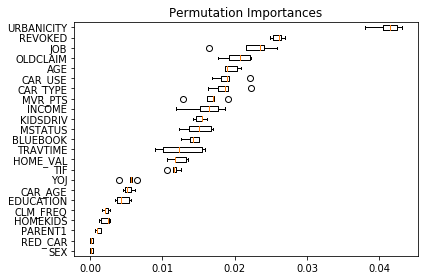

In [15]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()